# PAC Object Visibility - STARALT

Run all cells and fill in the date and RaDec coordinates like the example below.   
In the first cell the longitude(long) and latitude(lat) coordinates of the geographical location and the timezone(TZ) can be changed (wintertime = UTC +1, summertime = UTC +2).  
  
Example:   
Date (format: dd/mm/yyyy):   
&ensp; 27/08/2020  
Ra/Dec coordinates (format: name hh:mm:ss.ss ±dd:mm:ss.ss | put ',' between different coordinates):   
&ensp; NGC5706 14:39:36.28 +30:22:34.9, NGC5907 15:16:26 +56:15:09.6, Vega 18:37:38.70 +38:48:15.6

In [1]:
# Coordinates Blaauw Observatory  -->  06 32 11.2 E   53 14 24.9 N
long = 6 + 32/60 + 11.2/3600
lat = 53 + 14/60 + 24.9/3600
#alt = 25

TZ = 2  #timezone UTC +02:00

In [2]:
import numpy as np
from matplotlib.pyplot import figure, show, ylim, xlim, vlines, xticks, subplots
import matplotlib.ticker as mticker

def reduce24_0(t):
    """reduces a number in decimal hours into the range 0 to 24"""
    tr = (t/24 - int(t/24))*24    #reduce GST to the range 0-24h
    if tr <= 0:
        tr += 24
    return tr

reduce24 = np.vectorize(reduce24_0)

def reduce360(N):
    """reduces a number to the range 0 to 360"""
    Nr = (N/360 - int(N/360))*360    #reduce N to the range 0-360 degrees
    if Nr <= 0:
        Nr += 360
    return Nr

def hourminsec(ra):
    """"Input is an angle in decimal hours, 
    output is time in hh:mm:ss."""
    ra = reduce24(ra)
    h = int(ra)   #hours
    m = (ra - int(ra))*60   #minutes
    s = (m - int(m))*60    #seconds
    ra2 = f'{h}:{m:.0f}:{s:.2f}' 
    return ra2

hourminsec2 = np.vectorize(hourminsec)

def hourmin(ra):
    """"Input is an angle in decimal hours, 
    output is time in hh:mm."""
    ra = reduce24(ra)
    h = int(ra)   #hours
    m = (ra - int(ra))*60   #minutes
    ra2 = f'{h}h {m:.0f}m ' 
    return ra2

hourmin2 = np.vectorize(hourmin)

def juliandate(date):
    """conversion from gregorian calendar to julian date"""
    day, month, year = date.split('/')
    year = int(year); month = int(month); day = int(day)
    if month == 1 or month == 2:
        year -= 1
        month += 12

    #(for dates later than 15 October 1582)
    A = int(year/100)
    B = 2 - A + int(A/4)
    if year < 0:
        C = int((365.25*year)-0.75)
    else:
        C = int(365.25*year)
    D = int(30.6001*(month+1))

    JD = B + C + D + day + 1720994.5   #julian date
    return JD

In [3]:
def staralt(date, Coor, time):
    """Input are the date("dd/mm/yyyy") and the objects RA/Dec coordinates (name hh:mm:ss.ss ±dd:mm:ss.ss) and time
    Output is the altitude and airmass at the specified *local times"""
    day, month, year = date.split('/')
    year = int(year); month = int(month); day = int(day)
    
    name, RAstr, decstr = Coor.split()
    RAh, RAm, RAs = RAstr.split(":")
    RAh = int(RAh); RAm = int(RAm); RAs = float(RAs)
    decd, decm, decs = decstr.split(":")
    decd = int(decd); decm = int(decm); decs = float(decs)
    RA = RAh + RAm/60 + RAs/3600       # Right ascension in decimal hours
    dec = decd + decm/60 + decs/3600   # declination in decimal degrees
    
    long = 6 + 32/60 + 11.2/3600
    lat = 53 + 14/60 + 24.9/3600
    #alt = 25

    # TZ = 2  #timezone UTC +02:00
    
    JD = juliandate(date)     # Julian date
    
    # UT to GST
    S = JD - 2451545.0
    T = S/36525.0
    T0n = 6.697374558 + (2400.051336*T) + (0.000025862*T*T)
    T0 = reduce24(T0n)
    
    UT = time - TZ
    UTc = UT*1.002737909
    GST = T0 + UTc
    GST = reduce24(GST)
    
    #GST to LST
    longh = long/15  #longitude in decimal hours
    LST = reduce24(GST+longh)

    HA = LST - RA
    HA = reduce24(HA)  #hour angle in decimal hours
    
    #Equatorial to horizon coordinates
    HAr = HA*15 *np.pi/180   # hour angle in radians
    decr = dec *np.pi/180    #declination in radians
    latr = lat *np.pi/180   #latitude in degrees

    altr = np.arcsin(np.sin(decr)*np.sin(latr) + np.cos(decr)*np.cos(latr)*np.cos(HAr))  # altitude in radians
    altd = altr*180/np.pi
    Azr = np.arccos((np.sin(decr) - np.sin(latr)*np.sin(altr))/(np.cos(latr)*np.cos(altr))) # Azimuth in radians
    Azd = Azr*180/np.pi  #Azimuth in degrees
    Azd = np.where(np.sin(HAr) > 0, Azd, 360 - Azd)
    
    return altd, Azd, name

In [4]:
def sunpos(date):
    day, month, year = date.split('/')
    year = int(year); month = int(month); day = int(day)
    
    JD = juliandate(date)     # Julian date
    D = JD - juliandate("1/1/2010") + 1
    N = 360/365.242191 *D
    Nr = reduce360(N)
    
    T = (JD-2415020.0)/36525
    epsg = 279.557208    #degrees, Sun's mean eclipic longitude at epoch 2010
    omeg = 281.2208444 + 1.719175*T + 0.000452778*T*T   #degrees, longitude of Sun at perigee
    omeg = reduce360(omeg)    
    ecc  = 0.01675104 - 0.0000418*T - 0.000000126*T*T   # eccentricity
    
    Msun = reduce360(Nr + epsg - omeg)
    Ec  = 360/np.pi*0.016705*np.sin(Msun*np.pi/180)
    lamsun = reduce360(Nr + Ec + epsg)*np.pi/180
    T2 = (JD-2451545.0)/36525
    DE = (46.815*T2 + 0.0006*T2*T2 - 0.00181*T2**3)/3600
    obli = (23.439292 - DE)*np.pi/180   #radians, obliquity
    RAsun = np.arctan2((np.sin(lamsun)*np.cos(obli)),np.cos(lamsun))   #right ascension of sun 
    RAsun = reduce360(RAsun*180/np.pi)*np.pi/180
    decsun = np.arcsin(np.sin(obli)*np.sin(lamsun))    #declination sun
    CoorSun = f'Sun {hourminsec(RAsun*180/np.pi/15)} {hourminsec(decsun*180/np.pi)}'
    
    #------------------------------------------------------------------------
    lat = 53 + 14/60 + 24.9/3600    #geographical latitude groningen
    latr = lat *np.pi/180   #latitude in degrees
    
    v = 0.0   # ??vertical shift due to atmospheric refraction??
    v = 34/60 *np.pi/180 
    cosHA = -(np.sin(v) + np.sin(latr)*np.sin(decsun))/(np.cos(latr)*np.cos(decsun))
    if cosHA >= -1 and cosHA <= 1:
        HA = np.arccos(cosHA)*180/np.pi/15
    else:
        print("error: object never rises")
         
    LSTr = reduce24(RAsun*180/np.pi/15 - HA)
    LSTs = reduce24(RAsun*180/np.pi/15 + HA)
    Ar = np.arccos((np.sin(decsun) + np.sin(latr)*np.sin(v))/(np.cos(latr)*np.cos(v)))*180/np.pi
    Ar = reduce360(Ar)
    As = 360 - Ar
    
    #LST to GST to UT  (r=rising, s=setting)
    long = 6 + 32/60 + 11.2/3600  #degrees, geographical longitude
    longh = long/15     # decimal hours
    GSTr = LSTr - longh
    GSTs = LSTs - longh
    T0 = reduce24(6.697374558 + 2400.051336*T2 + 0.000025862*T2*T2)
    UTr = reduce24(GSTr - T0)*0.9972695663
    UTs = reduce24(GSTs - T0)*0.9972695663
    # TZ = 2  #timezone UTC +02:00
    LCTr = reduce24(UTr + TZ)     #Local civil time rising/setting sun
    LCTs = reduce24(UTs + TZ)
    
    z = 108*np.pi/180   #zenith angle sun for astronomical twilight
    cosHAtwi = (np.cos(z)-np.sin(latr)*np.sin(decsun))/(np.cos(latr)*np.cos(decsun))
    if cosHAtwi >= -1 and cosHAtwi <= 1:
        HAtwi = np.arccos(cosHAtwi)*180/np.pi/15
        t = (HAtwi-HA)*0.9973  #duration astronomical twilight
        LCTtwir = reduce24(LCTr - t)    #end of evening twilight
        LCTtwis = reduce24(LCTs + t)    #start of morning twilight  
    else:
        LCTtwir = None
        LCTtwis = None
    
    return LCTr, LCTs, LCTtwir, LCTtwis

Date (format: dd/mm/yyyy): 
 27/08/2020
Ra/Dec coordinates (format: name hh:mm:ss.ss ±dd:mm:ss.ss | put ',' between different coordinates): 
  NGC5706 14:39:36.28 +30:22:34.9, NGC5907 15:16:26 +56:15:09.6, Vega 18:37:38.70 +38:48:15.6


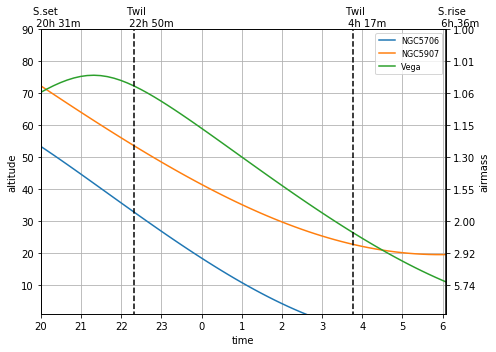

In [5]:
date = input("Date (format: dd/mm/yyyy): \n ")
Coor = input("Ra/Dec coordinates (format: name hh:mm:ss.ss ±dd:mm:ss.ss | put ',' between different coordinates): \n ")
CS = (Coor.split(','))

LCT1 = np.linspace(17.0,24.0,43)-24
LCT2 = np.linspace(0.0,10.0,61)
Ltime = np.concatenate((LCT1,LCT2))
a = hourmin2(Ltime)

Lr, Ls, Ltr, Lts = sunpos(date)
a=0; b=0
if Ls > Lr:
    a=24
if Lts > Ltr:
    b=24

fig = figure(figsize=(7,5))
fr = fig.add_subplot(1,1,1)
fr2 = fr.twinx()
fr.tick_params(axis='y')

vlines(Lr, 0, 90)
vlines(Ls-a, 0, 90)
fr.text(Lr-0.2, 91, f"S.rise \n {hourmin(Lr)}")
fr.text(Ls-0.2-a, 91, f"S.set \n {hourmin(Ls)}")

if Ltr != None:
    vlines(Ltr, 0, 90, linestyles='dashed')
    vlines(Lts-b, 0, 90, linestyles='dashed')
    fr.text(Ltr-0.2, 91, f"Twil \n {hourmin(Ltr)}")
    fr.text(Lts-0.2-b, 91, f"Twil \n {hourmin(Lts)}")
else:
    print("astronomical twilight lasts all night (it never gets completely dark)")

locs = np.arange(Ls-24, Lr+1)
xticks(locs, reduce24(locs).astype(int))
ylim(bottom=1, top=90)
fr.set_ylim(fr2.get_ylim())
xlim(left=Ls-a, right=Lr)

for Coors in CS:
    alt, Az, name = staralt(date, Coors, Ltime)
    fr.plot(Ltime, alt, '-', label=name)

def airmass(alt):
    Z = (90 - alt)*np.pi/180   #zenith distance
    m = (np.cos(Z) + 0.15*(93.885 - Z)**-1.253)**-1   #airmass
    return m

formatter = mticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(airmass(x)))
fr2.yaxis.set_major_formatter(formatter)
fr.set_xlabel('time')
fr.set_ylabel('altitude')
fr2.set_ylabel('airmass')
fr.grid(True)
fr.legend(loc=1, fontsize="8")

fig.tight_layout()
show()